<a href="https://colab.research.google.com/github/CloverMc0328/Group5-Project4/blob/main/Group5_Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Dependencies
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

spark_version = 'spark-3.5.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [47.6 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [632 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,535 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,265 kB]
Hit:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.la

In [ ]:
path = "/content/insurance.csv"
df = pd.read_csv(path)

df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
#data type check
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [ ]:
#check if any columns to null
null_df = df.isnull()
null_df.value_counts()

age    sex    bmi    children  smoker  region  charges
False  False  False  False     False   False   False      1338
dtype: int64

# **Identify Potential Outliners of Insurrance Charges in the DataFrame**

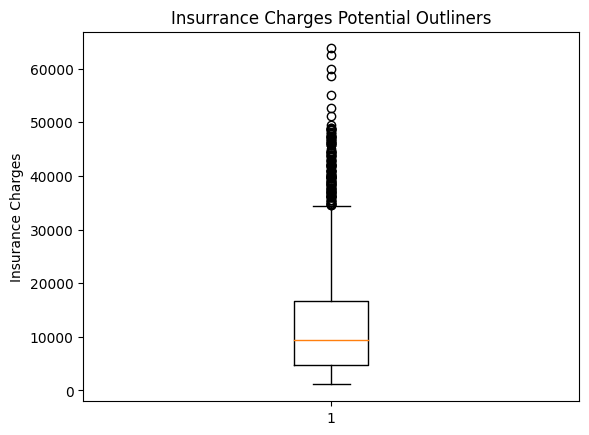

In [33]:
charges = df['charges'].values.tolist()
fig1, ax1 = plt.subplots()
ax1.set_title('Insurrance Charges Potential Outliners')
ax1.set_ylabel('Insurance Charges')
ax1.boxplot(charges)
plt.savefig('fig1.png')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [27]:
# Determine which data points are outside of the 1.5*IQR range
quartiles = np.quantile(charges,[.25,.75])
iqr = quartiles[1]-quartiles[0]
lower_bound = quartiles[0]-(1.5*iqr)
upper_bound = quartiles[1]+(1.5*iqr)

potential_outliers = [charge for charge in charges if charge < lower_bound or charge > upper_bound]
potential_outliers

[39611.7577,
 36837.467,
 37701.8768,
 38711.0,
 35585.576,
 51194.55914,
 39774.2763,
 48173.361,
 38709.176,
 37742.5757,
 47496.49445,
 37165.1638,
 39836.519,
 43578.9394,
 47291.055,
 47055.5321,
 39556.4945,
 40720.55105,
 36950.2567,
 36149.4835,
 48824.45,
 43753.33705,
 37133.8982,
 34779.615,
 38511.6283,
 35160.13457,
 47305.305,
 44260.7499,
 41097.16175,
 43921.1837,
 36219.40545,
 46151.1245,
 42856.838,
 48549.17835,
 47896.79135,
 42112.2356,
 38746.3551,
 42124.5153,
 34838.873,
 35491.64,
 42760.5022,
 47928.03,
 48517.56315,
 41919.097,
 36085.219,
 38126.2465,
 42303.69215,
 46889.2612,
 46599.1084,
 39125.33225,
 37079.372,
 35147.52848,
 48885.13561,
 36197.699,
 38245.59327,
 48675.5177,
 63770.42801,
 45863.205,
 39983.42595,
 45702.02235,
 58571.07448,
 43943.8761,
 39241.442,
 42969.8527,
 40182.246,
 34617.84065,
 42983.4585,
 42560.4304,
 40003.33225,
 45710.20785,
 46200.9851,
 46130.5265,
 40103.89,
 34806.4677,
 40273.6455,
 44400.4064,
 40932.4295,
 4041

In [31]:
numbers_of_potential_outliners = len(potential_outliers)
numbers_of_potential_outliners

139